In [1]:
%%bash
# wget https://huggingface.co/datasets/bsmock/pubtables-1m/resolve/main/PubTables-1M-Structure_Annotations_Val.tar.gz
# wget https://huggingface.co/datasets/bsmock/pubtables-1m/resolve/main/PubTables-1M-Structure_Images_Val.tar.gz

Couldn't find program: 'bash'


In [2]:
%%bash
# file PubTables-1M-Structure_Images_Val.tar.gz
# file PubTables-1M-Structure_Annotations_Val.tar.gz
# mkdir ./data
# tar -xvf PubTables-1M-Structure_Images_Val.tar.gz -C ./data/
# tar -xvf PubTables-1M-Structure_Annotations_Val.tar.gz -C ./data/

Couldn't find program: 'bash'


In [3]:
import os
import xml.etree.ElementTree as ET
from glob import glob
from PIL import Image
import shutil
classes = [
    'table column', 
    # 'table row', 
    # 'table spanning cell', 
    # 'table text cell'
]

def convert_coordinates(size, box):
    dw, dh = 1.0/size[0], 1.0/size[1]
    xmin, ymin, xmax, ymax = box
    w, h = xmax - xmin, ymax - ymin
    x_center, y_center = xmin + w/2, ymin + h/2
    return (x_center * dw, y_center * dh, w * dw, h * dh)

def convert_xml_to_yolo(xml_file, output_dir, image_dir):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find('filename').text
    image_path = os.path.join(image_dir, filename)
    
    # Read image dimensions using PIL
    with Image.open(image_path) as img:
        width, height = img.size

    output_filename = os.path.splitext(filename)[0] + '.txt'
    with open(os.path.join(output_dir, output_filename), 'w') as out_file:
        for obj in root.iter('object'):
            cls = obj.find('name').text
            if cls not in classes:
                continue

            cls_id = classes.index(cls)

            xmlbox = obj.find('bndbox')
            b = (float(xmlbox.find('xmin').text), float(xmlbox.find('ymin').text),
                 float(xmlbox.find('xmax').text), float(xmlbox.find('ymax').text))
            bb = convert_coordinates((width, height), b)
            out_file.write(f"{cls_id} {' '.join([str(a) for a in bb])}\n")

# Update the process_directory function to include the image_dir parameter
def process_directory(input_dir, output_dir, image_dir, nfiles = "all"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    xml_files = glob(os.path.join(input_dir, '*.xml'))

    if nfiles != "all":
        xml_files = xml_files[:nfiles]

    for xml_file in xml_files:
        convert_xml_to_yolo(xml_file, output_dir, image_dir)

def copy_corresponding_images(input_dir, image_dir, output_dir):
    # Get all YOLO annotation files in the output directory
    yolo_files = glob(os.path.join(input_dir, '*.txt'))

    for yolo_file in yolo_files:
        # Get the base filename without extension
        base_name = os.path.splitext(os.path.basename(yolo_file))[0]

        # Look for corresponding image file (supporting common image formats)
        for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
            image_file = os.path.join(image_dir, base_name + ext)
            if os.path.exists(image_file):
                # Copy the image to the output directory
                shutil.copy(image_file, output_dir)
                break  # Stop searching once the image is found and copied

In [4]:
import os
import yaml

def create_dataset_yaml(dataset_dir, yaml_path):
  # Create the dataset structure
  dataset = {
      'path': os.path.abspath(dataset_dir),
      'train': 'train',  # Assuming all data is for training
      'val': 'val',    # Using same data for validation
    #   'test': 'train',   # Using same data for testing
      'names': {i: name for i, name in enumerate(classes)},
      'nc': len(classes)
  }

  # Write the YAML file
  with open(yaml_path, 'w') as file:
      yaml.dump(dataset, file, default_flow_style=False)

  print(f"Dataset YAML file created at: {yaml_path}")

In [6]:
import os

n_samples = 10
data_dir = r"D:\.Capstone\workspace\data"
dataset_dir = r"D:\.Capstone\workspace\dataset"

# Create main dataset directory
os.makedirs(dataset_dir, exist_ok=True)

# Create train directories
train_images_dir = os.path.join(dataset_dir, "train", "images")
train_label_dir = os.path.join(dataset_dir, "train", "labels")
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_label_dir, exist_ok=True)

# Create validation directories
val_images_dir = os.path.join(dataset_dir, "val", "images")
val_label_dir = os.path.join(dataset_dir, "val", "labels")
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

image_dir = r"D:\.Capstone\workspace\data\PubTables-1M-Structure_Images_Val"
process_directory(r"D:\.Capstone\workspace\data\PubTables-1M-Structure_Annotations_Val", 
                  train_label_dir, 
                  image_dir, 
                  nfiles=1800)
process_directory(r"D:\.Capstone\workspace\data\PubTables-1M-Structure_Annotations_Val", 
                  val_label_dir, 
                  image_dir, 
                  nfiles=200)

copy_corresponding_images(train_label_dir, r"D:\.Capstone\workspace\data\PubTables-1M-Structure_Images_Val", train_images_dir)
copy_corresponding_images(val_label_dir, r"D:\.Capstone\workspace\data\PubTables-1M-Structure_Images_Val", val_images_dir)

create_dataset_yaml(dataset_dir, os.path.join(dataset_dir, "dataset.yaml"))

Dataset YAML file created at: D:\.Capstone\workspace\dataset\dataset.yaml


## Visualize the data

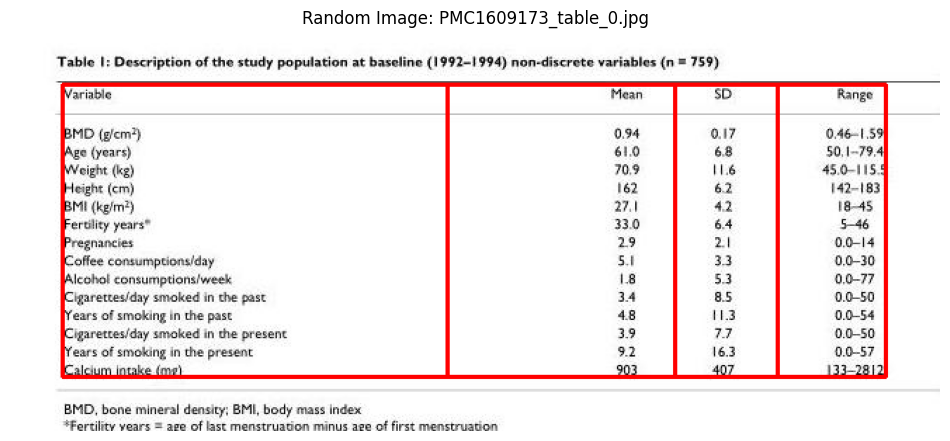

In [7]:
import yaml
import cv2
import matplotlib.pyplot as plt
import random
import os
import colorsys

# Load the dataset configuration
with open(r"D:\.Capstone\workspace\dataset\dataset.yaml", 'r') as file:
    dataset_config = yaml.safe_load(file)

# Get the dataset path and class names
dataset_path = dataset_config['path']
class_names = dataset_config['names']

# Choose a random set (train or val)
image_set = random.choice(['train', 'val'])
images_path = os.path.join(dataset_path, image_set, 'images')

# Get a list of all image files
image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Choose a random image
random_image = random.choice(image_files)
image_path = os.path.join(images_path, random_image)

# Load the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load the corresponding label file
label_path = os.path.join(dataset_path, image_set, 'labels', random_image.rsplit('.', 1)[0] + '.txt')

# Read and parse the label file
with open(label_path, 'r') as file:
    labels = file.readlines()

# Get image dimensions
height, width, _ = image.shape

# Function to generate distinct colors
def generate_colors(n):
    hsv_tuples = [(x / n, 1., 1.) for x in range(n)]
    return list(map(lambda x: tuple(round(i * 255) for i in colorsys.hsv_to_rgb(*x)), hsv_tuples))

# Generate a color for each class
colors = generate_colors(len(class_names))

# Draw bounding boxes and labels
for label in labels:
    class_id, x_center, y_center, box_width, box_height = map(float, label.strip().split())
    
    # Convert YOLO format to pixel coordinates
    x1 = int((x_center - box_width/2) * width)
    y1 = int((y_center - box_height/2) * height)
    x2 = int((x_center + box_width/2) * width)
    y2 = int((y_center + box_height/2) * height)
    
    # Get color for this class
    color = colors[int(class_id)]
    
    # Draw bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
    
    # Add label
    class_name = class_names[int(class_id)]
    # cv2.putText(image, class_name, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# Display the image
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')
plt.title(f"Random Image: {random_image}")
plt.show()